# Visualizing CNN features
> "Intro post on how to visualize features extracted from a CNN"
- comments: true
- categories: [CNN, jupyter, VGG, Transfer Learning]
- image: images/cnn.jpg
- author: Yassine M.


Chances you have heard of CNNs before and how they are used in computer vision.
A traditional multilayer Perceptrons do not take advantage of the importance of locality of pixel dependencies, instead, it flattens the images and sort of treats them as tabular data. We have come a long way since then. 

## A brief recap of convolutions

in theory, a convolution at x tires to measure the overlap between two functions in a specified bound where one is flipped and shifted by x

$$(f*g)(x) = \int f(z)g(x-z) \; dz $$

However, when dealing with images, they are discrete objects (the pixels) hence the integral can be simplified into a sum and for a two-dimension tensor: 

$$(f*g)(i,j) = \sum_a\sum_b f(a,b)g(i-a, j-b)  $$

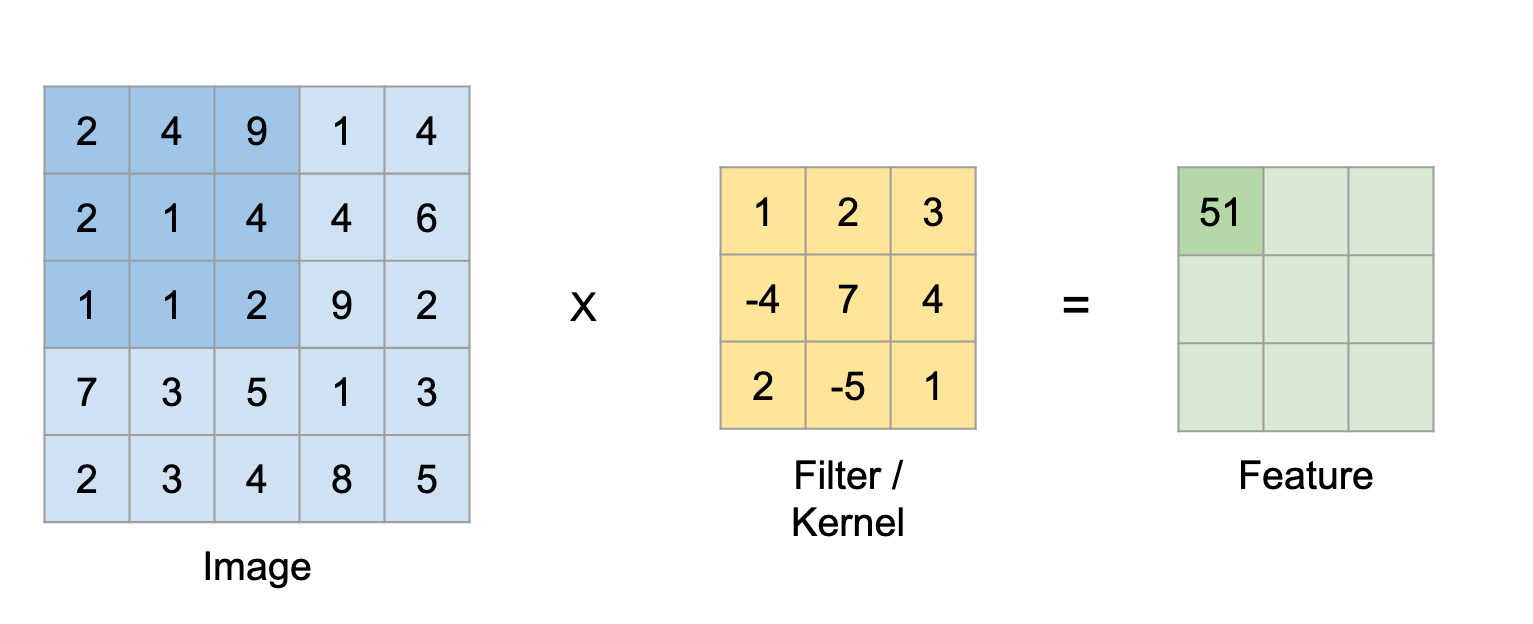

In [2]:
#collapse
from IPython.display import Image, display
display(Image('ghtop_images/conv.png'))

> so feature[0,0] = 2 x 1 + 4 x 2 + 3 x 9 + 2 x (-4) + 1 x 7 + 4 x 4 + 1 x 2 + 1 x (-5) + 2 x 1 = 51

a kernel, which also can be called a filter, tries to highlight or find a pattern in the image. In a complex deep learning model, the parameters of these filters cannot realistically be set manually or which filter should do what, instead, We just try to find a suitable architecture and hope we can learn the kernels

## Extracting Features

We can attempt to extract features from known architectures, a simple one from Vgg (Visual Geometry Group) using blocks. 
First, we import the pre-trained module, by default Vgg16 output is designed for 1000, we can add a linear layer and try to train only that layer which is shown below. We only need to set the imported parameters to be unlearnable and use our regular learning method 

In [3]:
import torchvision.models as models
vgg16 = models.vgg16(pretrained=True).cuda()

In [4]:
## Suppose for our problem, we only have 10 classes
import torch.nn as nn

class MyVgg16(nn.Module):
    def __init__(self):
        self.vgg16 = models.vgg16(pretrained=True).cuda()
        self.fc = nn.Linear(1000, 10)
        for p in self.vgg16.parameters():
            p.requires_grad = False
            
    def forward(self, x):
        x = self.vgg16(x)
        x = self.fc(x)    

### Dataset

I'm using this kaggle [dataset](https://www.kaggle.com/alessiocorrado99/animals10) which contains images for 10 different animal species, let's try to take a look at the animals

In [14]:
#collapse
from pathlib import Path
from data.translate import translate
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt
import os

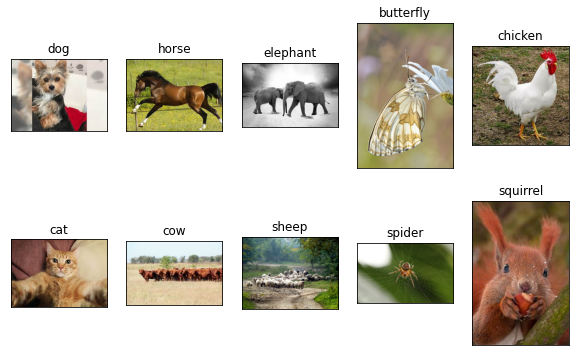

In [5]:
path = Path('data/raw-img')
classes = os.listdir(path) # in spanish
classes_en = list(map(lambda class_sp: translate[class_sp], classes)) # translate to english

def read_image(path, cl):
    img = Image.open(path)
    data = transforms.ToTensor()(img)
    return data, cl

# Get an images of each class
examples = []
for cl in classes:
    #print(len(os.listdir(path/cl)), translate[cl])
    p = str(path/cl/os.listdir(path/cl)[0])
    data = read_image(p, cl)
    examples.append(data[0])

_, axes = plt.subplots(nrows=2, ncols=5, figsize=(10, 6))
axes = axes.flatten()
for i, (ax, img) in enumerate(zip(axes, examples)):
    ax.imshow(transforms.ToPILImage()(img))
    ax.set_title(translate[classes[i]])
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)

In [6]:
from torch.utils.data import Dataset, DataLoader

class AnimalDataset(Dataset):
    def __init__(self, path):
        self.classes = os.listdir(path)
        self.images = []
        for i, cl in enumerate(self.classes):
            self.images.extend(list(map(lambda x: (path/cl/x, i), os.listdir(path/cl))))
                               
    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        path, label = self.images[idx]
        X = self._read_image(path)
        X = transforms.Resize((224, 224))(X)
        return X, label
    
    def _read_image(self, path):
        img = Image.open(path).convert('RGB')
        data = transforms.ToTensor()(img)
        return data

Next we create our feature extractor, we can specify the blocks input which is a list of all the block features we want. 

In [7]:
class Vgg16FeatureExtractor(nn.Module):
    def __init__(self, model, blocks):
        super().__init__()
        self.features = model.features
        self.blocks = blocks
        
    def forward(self, image, block=1, subplots=(2, 10)):
        data, y = image
        print(translate[dt.classes[y[0]]])
        plt.imshow(transforms.ToPILImage()(data[0]))
        features = []
        print(f'extracting feature from block {block}')
        channels = subplots[0] * subplots[1]
        _, axes = plt.subplots(*subplots, figsize=(15, 5))
        axes = axes.flatten()
        for channel, ax in enumerate(axes):
            im = self.features[:self.blocks[block]](data.cuda())[0][channel]
            features.append(im)
            im = transforms.ToPILImage()(im).resize((200, 200))
            ax.imshow(im)
            ax.set_title(f'channel {channel+1}')
            ax.axes.get_xaxis().set_visible(False)
            ax.axes.get_yaxis().set_visible(False)
        return features

In [8]:
path = Path('data/raw-img')
dt = AnimalDataset(path)
examples = iter(DataLoader(dt, batch_size=1, shuffle=True))

In [11]:
# define feature extractor with the features blocks below
feature_extractor = Vgg16FeatureExtractor(model=vgg16, blocks=[0, 5, 10, 19, 28])
example = next(examples)

chicken
extracting feature from block 1


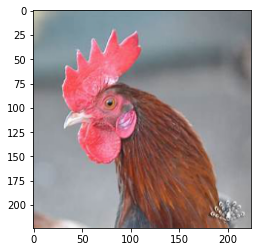

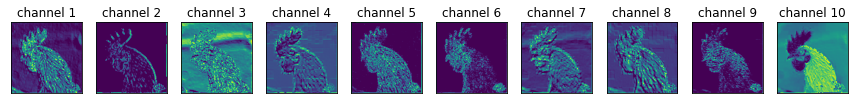

In [58]:
features = feature_extractor.forward(example, subplots=(1, 10))

chicken
extracting feature from block 2


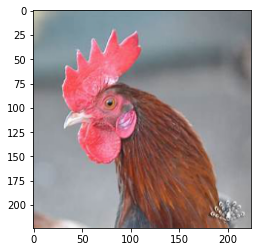

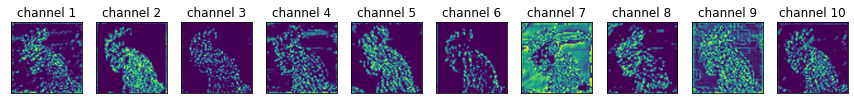

In [59]:
features = feature_extractor.forward(example, block = 2, subplots=(1, 10))

chicken
extracting feature from block 4


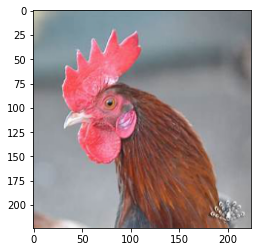

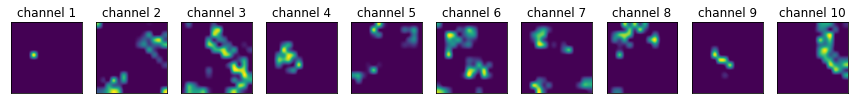

In [60]:
f = feature_extractor.forward(example, block = 4, subplots=(1, 10))

elephant
extracting feature from block 1


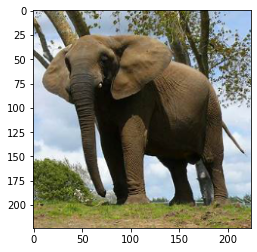

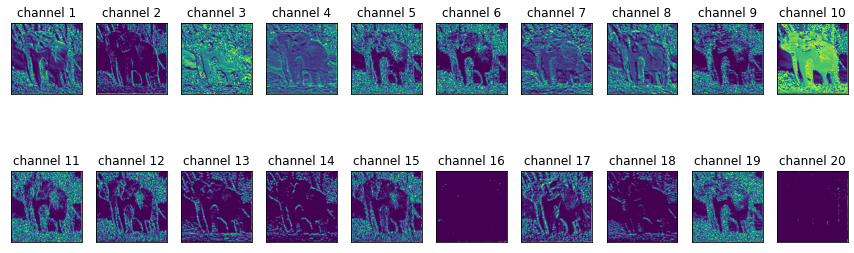

In [62]:
example = next(examples)
_ = feature_extractor.forward(example, block= 1, subplots=(2, 10))

dog
extracting feature from block 2


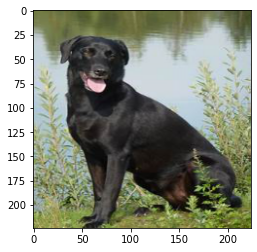

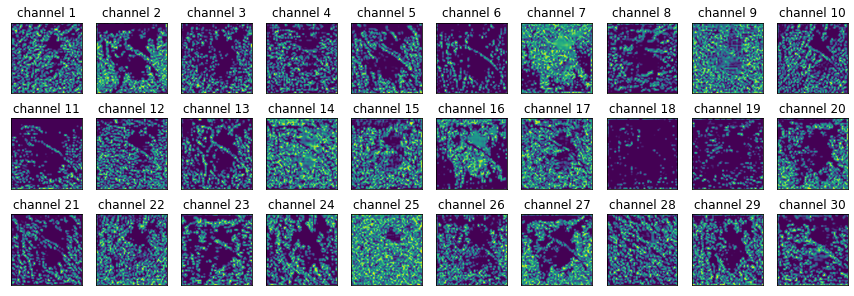

In [12]:
example = next(examples)
_ = feature_extractor.forward(example, block = 2, subplots=(3, 10))

spider
extracting feature from block 1


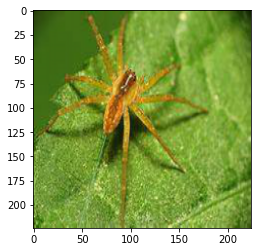

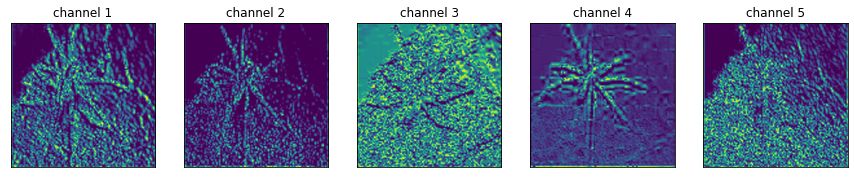

In [24]:
example = next(examples)
_ = feature_extractor.forward(example, block = 1, subplots=(1, 5))

# Conclusion

Hopefully this provides you an idea with how features that are being fed to a classifier look like. We have used VGG16 due to its simple architecture, also we are only showing the first channels given the `subplot` value. That being said, not every CNN model has a clear architecture that can be easily decomposed as as feature extractor and a classifier however it is achievable.  

I hope this excites you about Computer vision as it did to me when I first came across this, in the next post, we will build on the idea of feature extracting to transfer the art and style to another picture